# Clinical Notes Analysis – NER & Disease Classification
**Author:** Maria Kalimeri  
**Domain:** Application of NLP in Healthcare  
**Date:** October 2025

---

## 1. Introduction
In this project, I will use a dataset containing clinical notes to examine how Natural Language Processing techniques cam be applied to extract diseases, medications, and symptoms, as well as classify patient records into disease categories.  

**Goals:**
- Named Entity Recognition (NER)
- Entity linking with UMLS or SNOMED CT
- Disease classification
- Visualisation of insights

---

First, we need to import the necessary libraries. The installation of the libraries has been performed in a dedicated conda environment (see README.md). **If the environment has not been created yet, do this before continuing!**

In [1]:
# Imports

from collections import defaultdict
from pathlib import Path
import sys
import textwrap
from wordcloud import WordCloud

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scispacy
from scispacy.linking import EntityLinker
import seaborn as sns
import spacy
from spacy import displacy
from spacy.cli import download

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Install and import scispacy models
print('Geting scispacy models')
! python -m pip install "en_ner_bc5cdr_md @ https://huggingface.co/daviibrt/en_ner_bc5cdr_md/resolve/main/en_ner_bc5cdr_md-any-py3-none-any.whl" -q
import en_ner_bc5cdr_md


Your CPU supports instructions that this binary was not compiled to use: SSE4.1 SSE4.2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Geting scispacy models
DEPRECATION: Wheel filename 'en_ner_bc5cdr_md-any-py3-none-any.whl' is not correctly normalised. Future versions of pip will raise the following error:
Invalid wheel filename (invalid version): 'en_ner_bc5cdr_md-any-py3-none-any'

 pip 25.3 will enforce this behaviour change. A possible replacement is to rename the wheel to use a correctly normalised name (this may require updating the version in the project metadata). Discussion can be found at https://github.com/pypa/pip/issues/12938


Make sure the correct versions of Python/spacy/scispacy are being used

In [2]:
# Versions installed
print("Python executable:", sys.executable)
print("spaCy version:", spacy.__version__)
print("SciSpaCy version:", scispacy.__version__)

# Validate spaCy instalation
! python -m spacy validate

Python executable: /Users/mariakalimeri/opt/anaconda3/envs/nlp_env/bin/python
spaCy version: 3.6.1
SciSpaCy version: 0.5.3
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.6.1) =================
ℹ spaCy installation:
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/spacy

NAME                  SPACY            VERSION                            
en_ner_bc5cdr_md      >=3.6.1,<3.7.0   0.5.3   ✔
en_core_sci_scibert   >=3.6.1,<3.7.0   0.5.3   ✔



**Note regarding the scispacy model used**

As explained in the README file, in order to use scispacy, an older version of spacy, and other libraries, needed to be used. The scispacy libraries compatible with this version of spacy are not widely available. Specifically, I was able to only use library *en_ner_bc5cdr_md* succesfully. This library's pipeline contains the following components: tok2vec, tagger, attribute_ruler, lemmatizer, parser, ner

As a result, I was able to use this library for preprocessing of the text (tokenization, lemmatization) as well as for Named Entity Recognition (NER).

## 2. Dataset

I used a dataset available in Kaggle, which contains sample medical transcriptions for various medical specialties, scrapped from mtsamples.com [1]

**TODO 1**: The dataset has been manually download and saved locally. Update code to download it automatically from Kaggle, if not available
**TODO 2** I could also use a portion of MIMIC-III Clinical Database, also available in Kaggle https://www.kaggle.com/datasets/ihssanened/mimic-iii-clinical-databaseopen-access/data

In [3]:
# Get the dataset
file_path = "../data/mtsamples.csv"
transcriptions_df = pd.read_csv(file_path)

transcriptions_df.head()
transcriptions_df = pd.read_csv(file_path)
transcriptions_df.drop(columns="Unnamed: 0", inplace=True)

transcriptions_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Let's print an example of the text we will process

In [4]:
line_len = 120
sample_loc = 90

print(" TEXT EXAMPLE ".center(line_len))
print("\n")
sample_txt = transcriptions_df.transcription[sample_loc]
print(textwrap.fill(sample_txt,line_len))

                                                      TEXT EXAMPLE                                                      


PREOPERATIVE DIAGNOSIS:  ,Right ureteropelvic junction obstruction.,POSTOPERATIVE DIAGNOSES:,1.  Right ureteropelvic
junction obstruction.,2.  Severe intraabdominal adhesions.,3.  Retroperitoneal fibrosis.,PROCEDURES PERFORMED:,1.
Laparoscopic lysis of adhesions.,2.  Attempted laparoscopic pyeloplasty.,3.  Open laparoscopic pyeloplasty.,ANESTHESIA:,
General.,INDICATION FOR PROCEDURE:  ,This is a 62-year-old female with a history of right ureteropelvic junction
obstruction with chronic indwelling double-J ureteral stent.  The patient presents for laparoscopic
pyeloplasty.,PROCEDURE: , After informed consent was obtained, the patient was taken to the operative suite and
administered general anesthetic.  The patient was sterilely prepped and draped in the supine fashion after building up
the right side of the OR table to aid in the patient's positioning for bowel retr

## 3. Initial Data Exploration

Check data types, missing values

In [5]:
print(f"The dataset consists of {transcriptions_df.shape[0]} rows")

The dataset consists of 4999 rows


In [6]:
transcriptions_df.dtypes

description          object
medical_specialty    object
sample_name          object
transcription        object
keywords             object
dtype: object

In [7]:
def look_for_missing_values(df):
  null_percentages = df.isna().sum() / df.shape[0] * 100
  print("Percentage of rows with null values per column\n")
  for column, percentage in null_percentages.items():
      print(f"{column}: {percentage:.2f}%")

look_for_missing_values(transcriptions_df)

Percentage of rows with null values per column

description: 0.00%
medical_specialty: 0.00%
sample_name: 0.00%
transcription: 0.66%
keywords: 21.36%


We can see that column keywords is null for more that 20% of rows. This column is not going to be used anyway, so we can drop it. Next, we drop the rows that have null transcription.

In [8]:
transcriptions_df.drop(columns=['keywords'], axis=0, inplace=True)
transcriptions_df.dropna(inplace=True)

In [9]:
look_for_missing_values(transcriptions_df)

print(f"The dataset now consists of {transcriptions_df.shape[0]} rows")

Percentage of rows with null values per column

description: 0.00%
medical_specialty: 0.00%
sample_name: 0.00%
transcription: 0.00%
The dataset now consists of 4966 rows


## 4. Preprocessing

At this stage, the text needs to be preprocessed. Preprocessing involves convering all words to lowercase, removal of punctuation and stopwords, as well as making words into tokens and lemmatization, in order to eg. avoid the plural of a word to be consider a separate word.

In [10]:
nlp = spacy.load("en_ner_bc5cdr_md")

def preprocess(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

transcriptions_df['clean_text'] = transcriptions_df['transcription'].apply(preprocess)
transcriptions_df.head()

/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


,description,medical_specialty,sample_name,transcription,clean_text
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...",subjective white female present complaint alle...
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...",past MEDICAL HISTORY difficulty climb stair di...
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history PRESENT ILLNESS see ABC today pleasant...
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...",left atrial enlargement left atrial diameter n...
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ap...


## 5. Exploratory Data Analysis (EDA)


EDA will give some insight into the cleaned dataset, such as what are the most common words or expressions. This provides insights into the dataset and helps with downstream analysis.

The first attempt to visualise the data will be using a word cloud. This is an empirical way of finding the most common words in a text, and it is better performed after stopwords have been removed. It is important to add that the below word clouds only visualise single words and bigrams (two words together).

**Possible TODO** Visualise word cloud including trigrams as well

In [11]:
def create_word_cloud(txt, title):
    '''Creates a word cloud visualisation of the input

    txt (str)   : The input text
    title (str) : The title of the chart
    '''
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=True).generate(txt)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

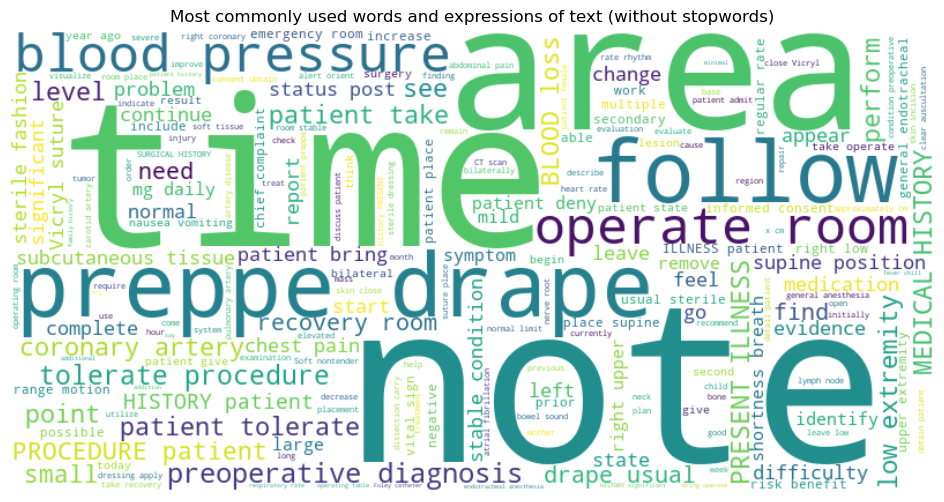

In [12]:
text = " ".join(transcriptions_df['clean_text'])
create_word_cloud(text, 'Most commonly used words and expressions of text (without stopwords)')

## 6. Named Entity Recognition (NER)

Now, we will perform NER on the text. 

- Extract diseases, medications, symptoms
- Visualize examples

The model (en_ner_bc5cdr_md) has been trained to recognise two entities - 'disease' and 'chemical', with F1 score 84% (https://allenai.github.io/scispacy/).

Let's first perform NER on one example and visualise the result. 

In [13]:
sample_doc = nlp(sample_txt)
displacy.render(sample_doc, style="ent", jupyter=True)

In this example, the model correctly recognises ureteropelvic junction obstruction as a 'disease'. We also see that 'IV antibiotics' is not recognised as a chemical compound, while the model extracted 'pain' as a disease, but ignored 'medications' which succeeds it. An alternative result would have been 'pain medication' recognised as 'chemical'.

In [14]:
print("TEXT", "ENTITY_TYPE")
for ent in sample_doc.ents:
    print(ent.text, ent.label_)

TEXT ENTITY_TYPE
ureteropelvic junction obstruction DISEASE
muscle caudate DISEASE
ureteropelvic junction obstruction DISEASE
fibrosis DISEASE
bowel injury DISEASE
ureteropelvic junction obstruction DISEASE
pain DISEASE


Now, let's extract entities from all transcriptions in the dataset. For each transcription, every entity will only be saved once, so there will be no dublicate disease or chemical in the same record.

In [15]:
def get_entities(txt):
    '''
    Uses scispacy model nlp (as defined above) to identify entities 
    and saves them in a defaultdict, to avoid duplication

    txt (str): the text from which we want to extract entities

    returns d (defaultdict)
    '''
    d = defaultdict()
    doc = nlp(txt)
    for ent in doc.ents:
        d[ent.text] = ent.label_
    return d

In [16]:
transcriptions_df['entities_dictionary'] = transcriptions_df.transcription.apply(get_entities)


In [17]:
transcriptions_df.iloc[sample_loc].entities_dictionary

defaultdict(None,
            {'ureteropelvic junction obstruction': 'DISEASE',
             'muscle caudate': 'DISEASE',
             'fibrosis': 'DISEASE',
             'bowel injury': 'DISEASE',
             'pain': 'DISEASE'})

Now, let's see the most common diseases and chemical compounds, as recognised by the model.

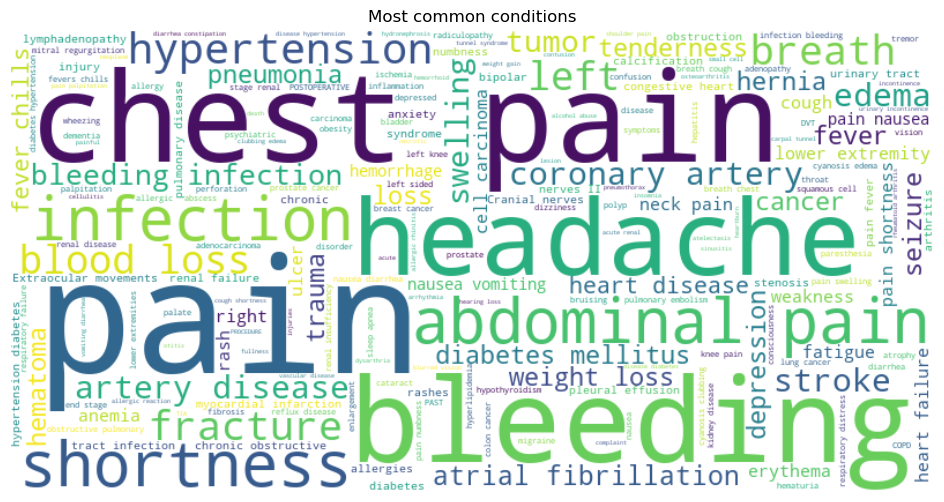

In [18]:
diseases = []
chemicals = []

def group_entities(d):
    '''
    Groups entities by type - specific to the 'CHEMICAL', 'DISEASE' entity types

    d (defaultdict): a dictionary that contains the key-value sets: entity_name:entity_type
    '''
    for e, l in zip(list(d.keys()), list(d.values())):
        if (l == "DISEASE"):
            diseases.append(e)
        elif (l == "CHEMICAL"):
            chemicals.append(e)
        else:
            pass
    return (diseases, chemicals)

groupred_entities = transcriptions_df.entities_dictionary.apply(group_entities)[0]

text = " ".join(groupred_entities[0])
create_word_cloud(text, 'Most common conditions')

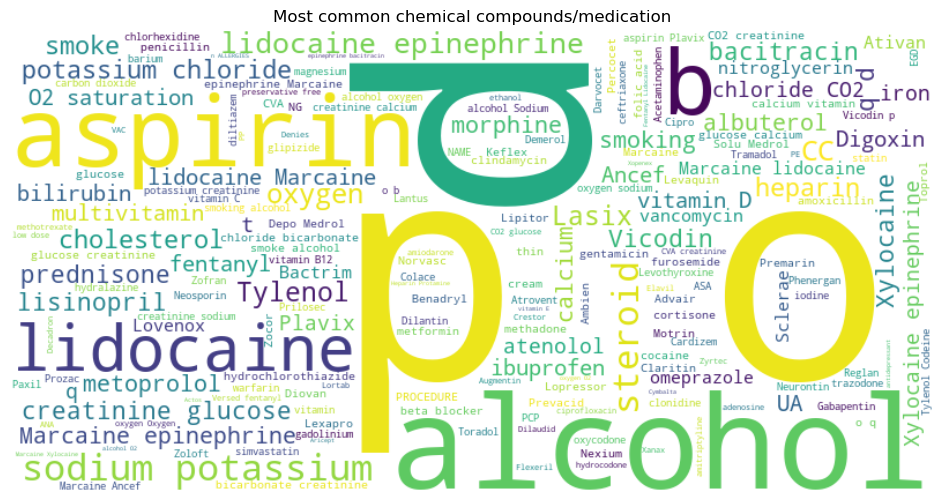

In [19]:
text = " ".join(groupred_entities[1])
create_word_cloud(text, 'Most common chemical compounds/medication')

The visualisations above show that common **conditions** are "pain" in general, as well as "chest pain" and "abdominal pain" in particular. "Headache", "coronary artery" and "artery disease" are also common. 

Common **chemicals** are alcohol, aspirin and lidocaine, but also "oxygen" is recognised as a chemical compound, which is true but might not be appropriate depending on the context. "p", "o" and "d" are alse commonly used.

## 7. Entity linking 

In the visualisation of most common diseases, we can see that both "blood loss" and "bleeding" are very commonly used. These two expressions/words mean the same thing, but they would be considered different for a machine learning model. This is something that occurs often in speech, and as a result, in clinical text. Another example would be "heart attack" and "myocardial infraction".

To address this, it is important to identify and standardize medical terms, which can be achieved by using medical terminology systems. Such systems are

- Unified Medical Language System (UMLS) [2], 
- Systematized Medical Nomenclature for Medicine–Clinical Terminology (SNOMED-CT) [3], and
- Medical Subject Headings (MeSH) [4].

These systems provide a comprehensive and standardized set of medical concepts, each uniquely identified by an alphanumeric code. 

So, now that we have identified diseases and chemical compounds in the previous step, we can map them to the standardized terms available in the medical terminology systems above. This can be done using the EntityLinker component of sciSpaCy.

### Example

First let's see what an entity linker does using one entity from our sample text. I will showcase the result using the linker to UMLS.

In [20]:
# nlp.remove_pipe("scispacy_linker")

In [21]:
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})
linker = nlp.get_pipe("scispacy_linker")


/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
def print_linked_entity(entity):
    print(f"Name: {entity.text} \n")
    # Each entity is linked to umls with a score
    if entity._.kb_ents:
        for i, link_ent in enumerate(entity._.kb_ents):
            print(f"RESULT NUMBER {i} \n")
            id, Score = link_ent
            print(f"Score = {Score} \n")
            print(linker.kb.cui_to_entity[link_ent[0]])
    else: 
        print("No results for this entity")

In [23]:
doc = nlp(transcriptions_df.transcription[90])

entity = doc.ents[0]
print_linked_entity(entity)

Name: ureteropelvic junction obstruction 

RESULT NUMBER 0 

Score = 1.0 

CUI: C0521619, Name: Obstruction of pelviureteric junction
Definition: A usually congenital abnormality characterized by the partial obstruction of the junction between the renal pelvis and ureter. It may lead to hydronephrosis.
TUI(s): T190
Aliases (abbreviated, total: 13): 
	 PUJ - Pelviureteric obstruction, Ureteropelvic junction obstruction, Pelviureteric obstruction, Obstruction of pelviureteric junction (disorder), Ureteropelvic Junction Obstruction, Ureteropelvic junction stenosis, Pelviureteric junction obstruction, Pelvi-ureteric junction obstruction, PUO - Pelviureteric obstruction, Obstruction of pelviureteric junction
RESULT NUMBER 1 

Score = 1.0 

CUI: C5574705, Name: CONGENITAL ANOMALIES OF KIDNEY AND URINARY TRACT 2
Definition: None
TUI(s): T047
Aliases: (total: 6): 
	 PELVIURETERIC JUNCTION OBSTRUCTION, CAKUT2, URETEROPELVIC JUNCTION OBSTRUCTION, UPJO, CONGENITAL ANOMALIES OF KIDNEY AND URINARY 

In this case, there are five matches in the UMLS terminology system. But it is possible that no match is found, as showcased in the example below.

In [24]:
entity = doc.ents[1]    

print_linked_entity(entity)

Name: muscle caudate 

No results for this entity


### Link all entities 

In [25]:
def link_entity(text):
    linked_dict = {}
    entities = nlp(text).ents
    for entity in entities:
        linked_dict[entity] = entity._.kb_ents
    return linked_dict

In [26]:
transcriptions_df['linked_entities'] = transcriptions_df.transcription.apply(link_entity)


In [27]:
# Example of linked entities - get details
linked_ents = transcriptions_df.linked_entities[sample_loc]
keys = list(linked_ents.keys())
k=keys[0]

link_ent = linked_ents[k]
for i, l in enumerate(link_ent):
    print(f'{k}: RESULT {i} \n')
    print(f'{linker.kb.cui_to_entity[l[0]]} \n')


ureteropelvic junction obstruction: RESULT 0 

CUI: C0521619, Name: Obstruction of pelviureteric junction
Definition: A usually congenital abnormality characterized by the partial obstruction of the junction between the renal pelvis and ureter. It may lead to hydronephrosis.
TUI(s): T190
Aliases (abbreviated, total: 13): 
	 PUJ - Pelviureteric obstruction, Ureteropelvic junction obstruction, Pelviureteric obstruction, Obstruction of pelviureteric junction (disorder), Ureteropelvic Junction Obstruction, Ureteropelvic junction stenosis, Pelviureteric junction obstruction, Pelvi-ureteric junction obstruction, PUO - Pelviureteric obstruction, Obstruction of pelviureteric junction 

ureteropelvic junction obstruction: RESULT 1 

CUI: C5574705, Name: CONGENITAL ANOMALIES OF KIDNEY AND URINARY TRACT 2
Definition: None
TUI(s): T047
Aliases: (total: 6): 
	 PELVIURETERIC JUNCTION OBSTRUCTION, CAKUT2, URETEROPELVIC JUNCTION OBSTRUCTION, UPJO, CONGENITAL ANOMALIES OF KIDNEY AND URINARY TRACT 2, PU

## 8. Classification – Disease Category


## 9. Conclusion & Insights


## 10. Resources

[1] https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions?resource=download

[2] Bodenreider O. (2004). The Unified Medical Language System (UMLS): integrating biomedical terminology. Nucleic acids research, 32(Database issue), D267–D270. https://doi.org/10.1093/nar/gkh061

[3] https://www.nlm.nih.gov/healthit/snomedct/index.html

[4] https://www.nlm.nih.gov/mesh/meshhome.html


**Interesting articles**

https://towardsdatascience.com/building-a-biomedical-entity-linker-with-llms-d385cb85c15a/
